<a href="https://colab.research.google.com/github/pharringtonp19/rfp/blob/main/notebooks/Missing_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Install Modules**

In [1]:
#@title  { display-mode: "form" }
%%capture 
!pip install flax
!pip install optax
!pip install tree-math

### **Import Modules**

In [2]:
#@title  { display-mode: "form" }
import jax
import flax
from jax import grad, vmap, jit, random, value_and_grad, tree_map, numpy as jnp 
from functools import partial
import tree_math as tm 

from typing import Sequence # Used to define Flax Model
import flax.linen as nn     # Used to define Flax Model
import optax                # Neural Network Optimizer
from optax import set_to_zero 
import math

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### **Plot Functions**

In [3]:
#@title { display-mode: "form" }
def plot_data(batch):
  X, Y = batch
  fig = plt.figure(dpi=300, tight_layout=True, figsize=(6.4, 4.8))
  for i in range(X.shape[0]):
    plt.scatter(X[i], Y[i], label=i)
  plt.legend(title=r'$E[Y|C=i]$', ncol=2, fontsize='xx-small')
  plt.title(r'$Y$', loc='left')
  plt.xlabel(r'$X$')
  fig.savefig('motivating_cefs.pdf', format='pdf')
  plt.show()

### **Data**

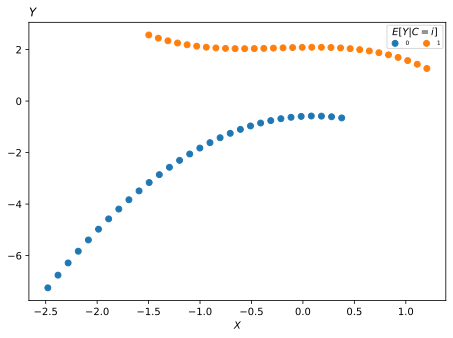

In [4]:
#@title  { display-mode: "form" }
def polynomial(weights, x):
  return weights[0] + weights[1]*x + .5*weights[2]*x**2 + (1/6)*weights[3]*x**3

def get_data(key, n_obs):
  key, subkey1, subkey2, subkey3 = random.split(key, 4)
  x_start = random.uniform(subkey1, shape=(1,), minval=-3., maxval=-1.)
  lenth = random.uniform(subkey2, shape=(1,), minval=1., maxval=4.)
  x = jnp.linspace(x_start, x_start + lenth, n_obs)
  weights = random.normal(subkey3, shape=(4,))
  y = vmap(polynomial, in_axes=(None, 0))(weights, x)
  return x, y

n_obs = 30
n_cohorts = 2
batch = vmap(get_data, in_axes=(0, None))(random.split(random.PRNGKey(5), n_cohorts), n_obs)
single_x, single_y = batch[0].squeeze().reshape(-1,1), batch[1].squeeze().reshape(-1,1)
plot_data(batch)

### **Model**

In [5]:
#@title  { display-mode: "form" }
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact 
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x 

def init_fn(seed):

  # Initialize Model
  rng = random.PRNGKey(seed)
  params = flax.core.unfreeze(model.init(rng, jnp.ones((1, 1))))['params']
  
  return params

def optimal_params(state):
  params = param_reshaper.reshape(state['best_member'].reshape(1,-1))
  leaves, treedef = jax.tree_flatten(params)
  params = [treedef.unflatten(x) for x in zip(*leaves)][0]
  return params  

def predict(params, inputs):
  return model.apply({"params": params}, inputs)

### **Loss Functions**

In [6]:
def loss_fn(params, inputs, targets):
    predictions = model.apply({"params": params}, inputs)
    return jnp.mean((targets - predictions)**2)

def maml_loss_fn(params, n_inner_epochs, inputs, targets):

  def update(carry, t):
    params, opt_state = carry 
    loss, grads = value_and_grad(loss_fn)(params, inputs, targets)
    updates, opt_state = inner_gradient_processor.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return (params, opt_state), (loss)
  (opt_params, _), _ = jax.lax.scan(update, (params, inner_gradient_processor.init(params)), None, length=n_inner_epochs)
  return loss_fn(opt_params, inputs, targets)


def avg_maml(params, n_inner_epochs, inputs, targets):
  return jnp.mean(vmap(maml_loss_fn, in_axes=(None, None, 0, 0))(params, n_inner_epochs, inputs, targets))

### **Training Loop**

In [7]:
#@title  { form-width: "1%", display-mode: "form" }
@partial(jit, static_argnums=(1,2))
def train(params, n_epochs, n_inner_epochs, inputs, targets):

  def update(carry, t):
    params, opt_state = carry 
    loss, grads = value_and_grad(avg_maml)(params, n_inner_epochs, inputs, targets)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return (params, opt_state), (loss)
  (opt_params, _), losses = jax.lax.scan(update, (params, opt.init(params)), None, length=n_epochs)
  return opt_params, losses

### **Train Model**

In [8]:
#@title  { form-width: "1%", display-mode: "form" }
layers = [32, 32, 1]
layer_freeze = [False, False, False]
int_layer_freeze = map(int, layer_freeze)
n_epochs = 1000
n_inner_epochs = 1000
model = MLP(layers)
params = init_fn(0)
opt = optax.sgd(learning_rate=0.001)
inner_gradient_processor = optax.multi_transform({"train":optax.sgd(learning_rate=0.001, momentum=0.9), "zero": set_to_zero()},
                          {f"Dense_{i}": "zero" if j else "train" for (i, j) in enumerate(layer_freeze)})
opt_params, results = train(params, n_epochs, n_inner_epochs, batch[0], batch[1])

In [9]:
inital_loss = jnp.mean(jax.vmap(loss_fn, in_axes=(None, 0, 0))(params, batch[0], batch[1]))

### **Plot Results**

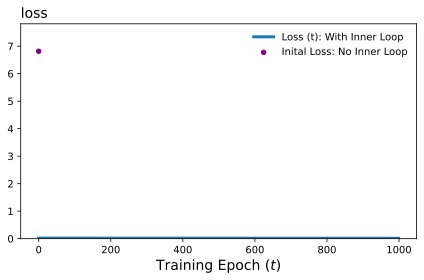

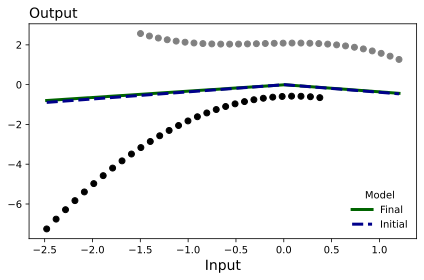

In [10]:
#@title  { form-width: "1%", display-mode: "form" }
fig, ax0 = plt.subplots(nrows=1, ncols=1, tight_layout=True)
ax0.set_title('loss', loc='left', size=14)
ax0.scatter(0, inital_loss.item(), color= 'purple', s=20, label='Inital Loss: No Inner Loop')
ax0.plot(results, linewidth=3, label='Loss (t): With Inner Loop')
ax0.set_ylim(0,inital_loss.item()+ 1)
ax0.legend(frameon=False)
ax0.set_xlabel(r'Training Epoch $(t)$', size=14)
fig.savefig('full_inner_loop.png', format='png')
plt.show()

colors = ['black', 'grey']
fig = plt.figure(dpi=300, tight_layout=True)
for i in range(n_cohorts):
  plt.scatter(batch[0][i], batch[1][i], color=colors[i])
  x = jnp.linspace(jnp.min(batch[0]), jnp.max(batch[0]), 1000).reshape(-1,1)
plt.title('Output', size=14, loc='left')
plt.xlabel('Input', size=14)
plt.plot(x, model.apply({"params": opt_params}, x), color='darkgreen', label='Final', linewidth=3, linestyle='-')
plt.plot(x, model.apply({"params": params}, x), color='darkblue', label='Initial', linewidth=3, linestyle='--')
plt.legend(frameon=False, loc='lower right', title='Model')
fig.savefig('full_inner_loop_models.png', format='png')
plt.show()